# Wide parameter space searches and Machine learning for CW detection
Joe Bayley

Department of Physics and Astronomy

Univeristy of Glasgow

Searches for continuous gravitational waves come in a number of forms, generally targeted, directed and all-sky depending on the prior knowledge of the source. The following tutoral will be focussing on all-sky searches where there is no known prior knowledge of the source.

There are two main parts to this tutorial:
 * SOAP - the core SOAP algorithm and how to apply it to LIGO/Virgo/Kagra data
 * ML - how to apply machine learning to the same data-set (in this case for detection, in reality it is used more for line-vetoing)

 You can open this notebook in colab, which has some small amount of access to GPUs for free:
 
 [![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/jcbayley/cwworkshop/blob/main/cwworkshop_soap.ipynb)

 The datasets we will use throughout this tutoral are much smaller than we will realistically get, 


## Installing and importing libraries

In [ ]:
!pip install soapcw

In [159]:
import numpy as np
import matplotlib.pyplot as plt
import soapcw
from soapcw import cw
import h5py
import torch
import os
import copy

## Downloading data

In [160]:
def fetch_data(url, filename):
    """Fetch data from a url and save it to given file"""
    if not os.path.isfile(filename):
        import urllib
        urllib.request.urlretrieve(url, filename=filename)
    else:
        print("File already exists!")

In [161]:
os.makedirs("data", exist_ok=True)
os.makedirs("pretrained_model_config", exist_ok=True)
even_url = "https://github.com/jcbayley/cwworkshop/raw/main/data/freq_100.0_106.1_3120_even.hdf5"
even_file = "data/freq_100.0_106.1_3120_even.hdf5"
fetch_data(even_url, even_file)
# Now for the training data
odd_url = "https://github.com/jcbayley/cwworkshop/raw/main/data/freq_100.0_106.1_3120_odd.hdf5"
odd_file = "data/freq_100.0_106.1_3120_odd.hdf5"
fetch_data(odd_url, odd_file)
# Now for model weights
weight_url = "https://github.com/jcbayley/cwworkshop/raw/main/pretrained_model_config/model_vitmapspectrogram_for_odd.pt"
weight_file = "pretrained_model_config/model_vitmapspectrogram_for_odd.pt"
fetch_data(weight_url, weight_file)
# Now for  config
config_url = "https://github.com/jcbayley/cwworkshop/raw/main/pretrained_model_config/pre_model.ini"
config_file = "pretrained_model_config/pre_model.ini"
fetch_data(config_url, config_file)

File already exists!
File already exists!


# SOAP

Documentation: https://joseph.bayley.docs.ligo.org/soapcw/viterbialgorithm.html 

SOAP (Snakes On A Plane) is a method to rapidly search for long duration signals in time-frequency spectrograms which do not follow any particular frequency evolution. This has the main goal of identifying signals that may be missed by traditional searches which use information on the expected signal to search for a signal.

There are multiple components to the SOAP search:
1. Initial frequency track identification (model agnostic)
2. ML followup to penalise instrumental lines (some model dependence)
3. Source parameter estimation from frequency tracks (model dependence)


##  Data Generation
Usage: https://joseph.bayley.docs.ligo.org/soapcw/usage/generate_cw_signal.html 

The SOAP package also has the ability to simulate spectrograms (i.e. time-frequency power spectra) of a CW signal. These are by default injected assuming the signal time-series is in stationary Gaussian noise, however, the PSD for each SFT can be changed and a signal can also be injected into real data. 

In [162]:
sig = cw.GenerateSignal()
# define signal parameters
sig.alpha = 3.310726752188296
sig.delta = -0.8824241920781501
sig.cosi = -0.63086
sig.phi0 = 4.007
sig.psi = 0.52563
sig.f = [100.02,-1e-17,0]
sig.tref = 946339148.816094
#sig.h0 = 3e-24   #can be used along with a noise floor value, but we'll just just SNR

In [163]:
nsft, tstart, tsft, flow, fhigh = 48*200, 931042949, 1800., 100.0,100.1
snr = 65

In [164]:
spect = sig.get_spectrogram(
    tstart = tstart, 
    nsft=nsft,
    tsft=tsft,
    fmin=flow,
    fmax=fhigh,
    dets=["H1", "L1"],
    snr=snr)

XLAL Error - XLALReadEphemerisFile (LALInitBarycenter.c:482): Failed to find ephemeris-file 'earth00-19-DE405.dat.gz[.gz]'

XLAL Error - XLALReadEphemerisFile (LALInitBarycenter.c:482): Invalid argument
XLAL Error - XLALInitBarycenter (LALInitBarycenter.c:252): XLALReadEphemerisFile('earth00-19-DE405.dat.gz') failed

XLAL Error - XLALInitBarycenter (LALInitBarycenter.c:252): Internal function call failed: Invalid argument


Could not load ephemeris file: earth00-19-DE405.dat.gz sun00-19-DE405.dat.gz, Internal function call failed: Invalid argument


Spectrograms are usually summed over 1 day to remove the antenna pattern modulation and increase the SNR (assuming the signal stays within a single frequency bin for a day).

In [165]:
spect.sum_sfts()

In [166]:
h1_pulsar_path = sig.get_pulsar_path(spect.epochs, "H1")
h1_summed_pulsar_path = np.mean(np.split(h1_pulsar_path, int(len(h1_pulsar_path)/48)), axis=1)

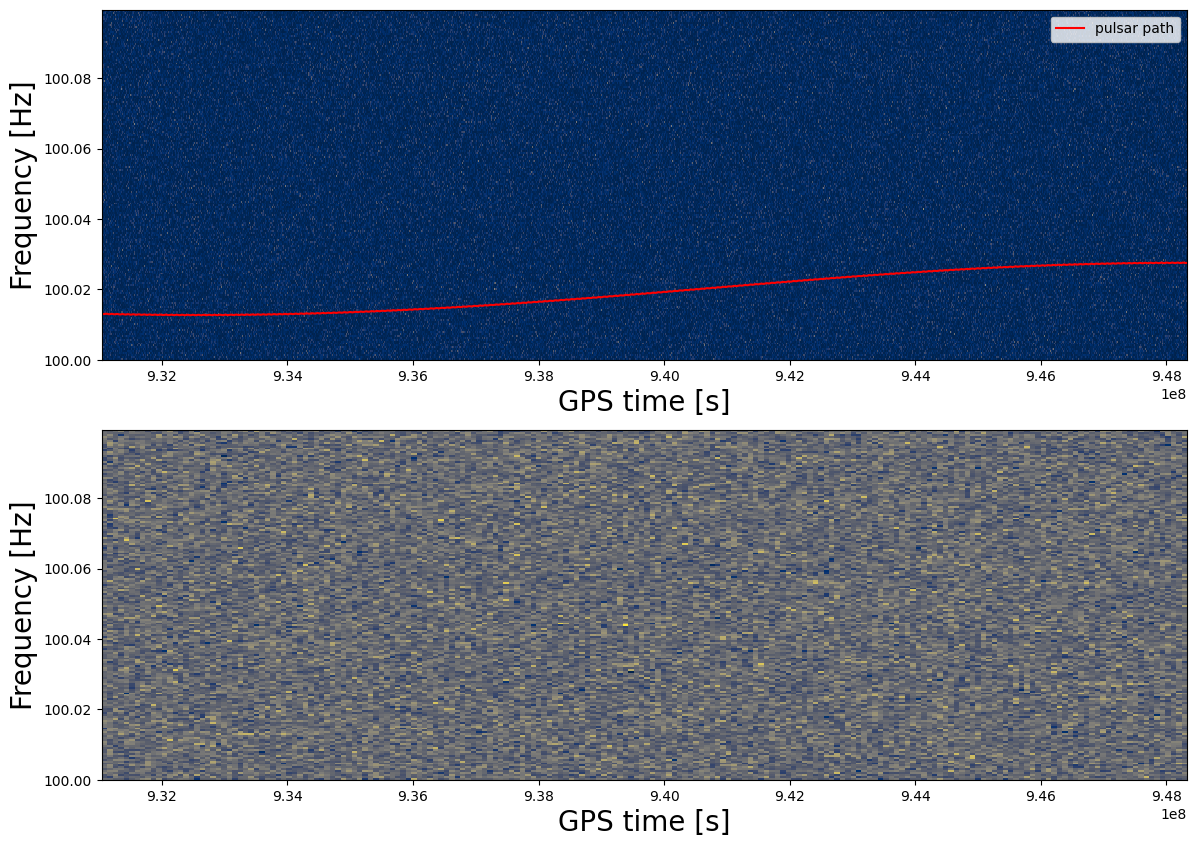

In [167]:
fig, ax = plt.subplots(nrows=2,figsize=(14,10))
ax[0].imshow(spect.H1.norm_sft_power.T,aspect="auto",origin="lower",extent=[spect.epochs.min(),spect.epochs.max(),spect.frequencies.min(),spect.frequencies.max()],cmap="cividis", interpolation="none")
ax[1].imshow(spect.H1.summed_norm_sft_power.T,aspect="auto",origin="lower",extent=[spect.epochs.min(),spect.epochs.max(),spect.frequencies.min(),spect.frequencies.max()],cmap="cividis", interpolation="none")
ax[0].plot(spect.epochs, h1_pulsar_path, "r", label="pulsar path")
ax[0].set_xlabel("GPS time [s]",fontsize=20)
ax[0].set_ylabel("Frequency [Hz]",fontsize=20)
ax[1].set_xlabel("GPS time [s]",fontsize=20)
ax[1].set_ylabel("Frequency [Hz]",fontsize=20)
ax[0].legend()

## Transisiton matrix
Documentation: https://joseph.bayley.docs.ligo.org/soapcw/transitionmatrix.html

The transition matrix defines the constraints that are placed on the track as it iterates between one time step and the next. In this case we are using multiple detectors therefore there are three components to the transition matrix. (up/down probability, geocenter to detector 1 probability, geocenter to detector 2 probability).

In [168]:
transition_matrix = soapcw.tools.transition_matrix_2d(1.1, 1e200,1e200)
print(transition_matrix)

[[[         -inf -461.64842071          -inf]
  [-461.64842071   -1.13140211 -461.64842071]
  [         -inf -461.64842071          -inf]]

 [[         -inf -461.55311053          -inf]
  [-461.55311053   -1.03609193 -461.55311053]
  [         -inf -461.55311053          -inf]]

 [[         -inf -461.64842071          -inf]
  [-461.64842071   -1.13140211 -461.64842071]
  [         -inf -461.64842071          -inf]]]


/Users/joebayley/miniconda3/envs/soapcw/lib/python3.9/site-packages/soapcw/tools/tools.py:115: RuntimeWarning: divide by zero encountered in log
  return np.log(tr/np.sum(tr))


The SOAP algorithm can then be run by inputting the two normalised and summed spectrograms and the transition matrix.

In [169]:
soapout = soapcw.two_detector(transition_matrix, spect.H1.summed_norm_sft_power, spect.H1.summed_norm_sft_power)

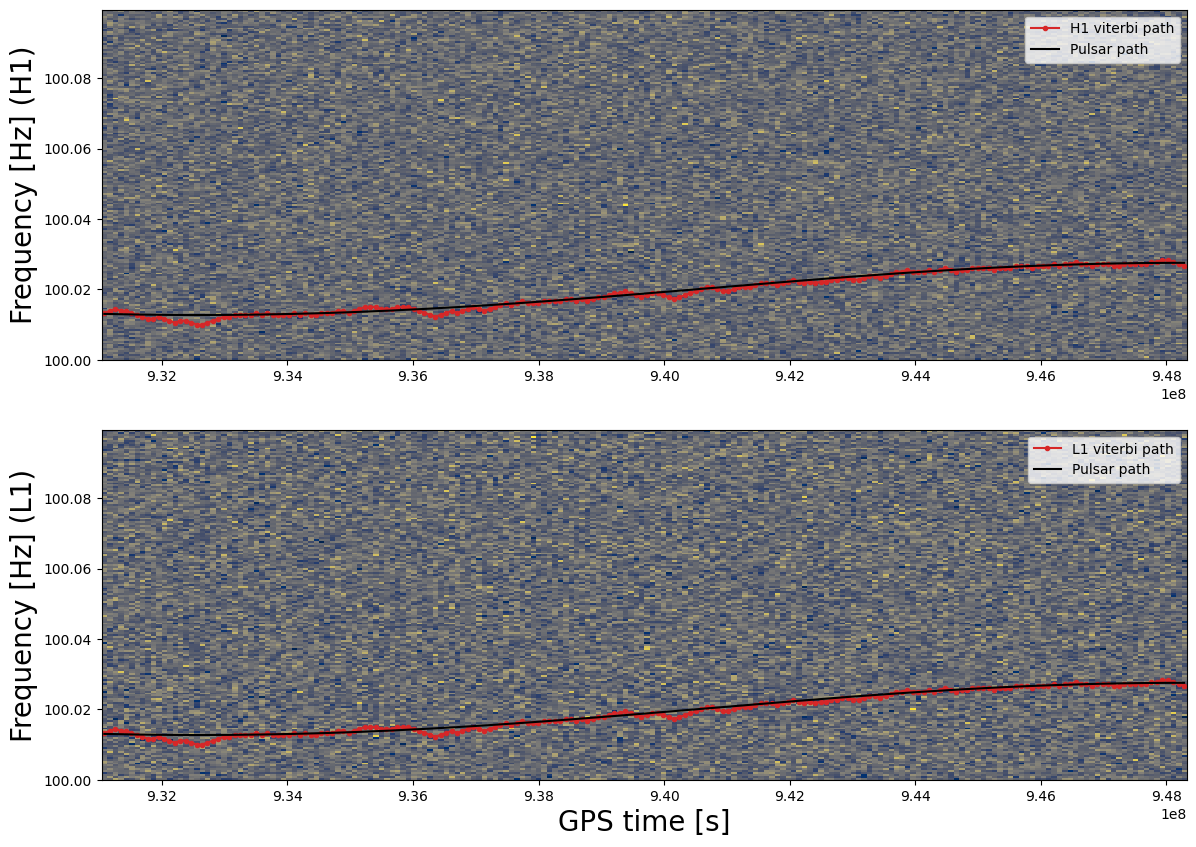

In [170]:
fig, ax = plt.subplots(nrows=2,figsize=(14,10))
half_day = 12*3600
ax[0].imshow(spect.H1.summed_norm_sft_power.T,aspect="auto",origin="lower",extent=[spect.epochs.min(),spect.epochs.max(),spect.frequencies.min(),spect.frequencies.max()],cmap="cividis", interpolation="none")
ax[1].imshow(spect.L1.summed_norm_sft_power.T,aspect="auto",origin="lower",extent=[spect.epochs.min(),spect.epochs.max(),spect.frequencies.min(),spect.frequencies.max()],cmap="cividis", interpolation="none")
ax[0].plot(spect.epochs[::48] + half_day, spect.frequencies[soapout.vit_track1], color="C3", marker="o", ms=3, label="H1 viterbi path")
ax[1].plot(spect.epochs[::48] + half_day, spect.frequencies[soapout.vit_track2], color="C3", marker="o", ms=3, label="L1 viterbi path")
ax[0].plot(spect.epochs[::48] + half_day, h1_summed_pulsar_path, color="k", label="Pulsar path")
ax[1].plot(spect.epochs[::48] + half_day, h1_summed_pulsar_path, color="k", label="Pulsar path")
ax[1].set_xlabel("GPS time [s]",fontsize=20)
ax[0].set_ylabel("Frequency [Hz] (H1)",fontsize=20)
ax[1].set_ylabel("Frequency [Hz] (L1)",fontsize=20)
ax[0].legend()
ax[1].legend()

/var/folders/5g/x3mq__7j4q19_ymmlzpqqt9c0000gq/T/ipykernel_69278/429835647.py:2: RuntimeWarning: divide by zero encountered in log
  img=ax.imshow(np.log(soapout.vitmap.T), origin="lower", aspect="auto", extent=[spect.epochs.min(),spect.epochs.max(),spect.frequencies.min(),spect.frequencies.max()],cmap="cividis", interpolation="none")


Text(0, 0.5, 'Frequency [Hz]')

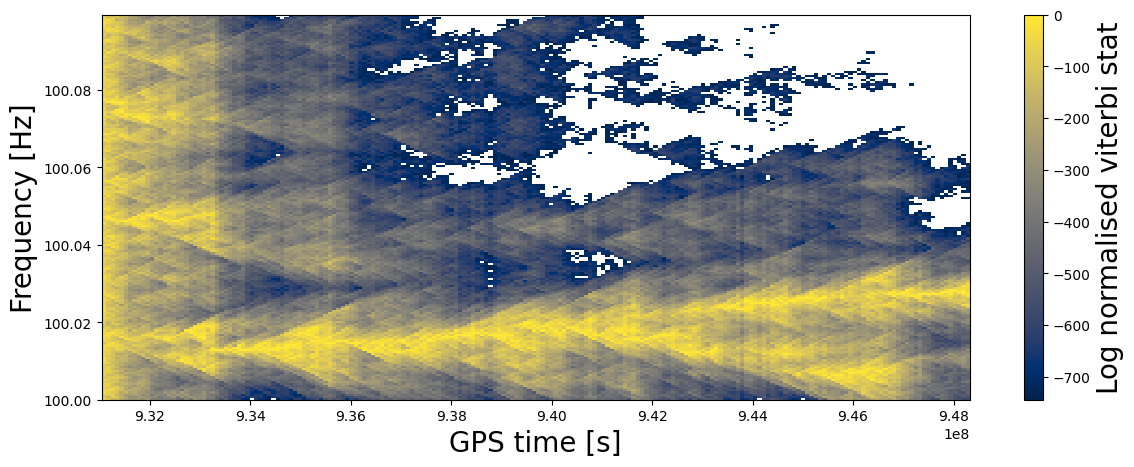

In [171]:
fig, ax = plt.subplots(figsize=(14,5))
img=ax.imshow(np.log(soapout.vitmap.T), origin="lower", aspect="auto", extent=[spect.epochs.min(),spect.epochs.max(),spect.frequencies.min(),spect.frequencies.max()],cmap="cividis", interpolation="none")
cbar = fig.colorbar(img, ax=ax)
cbar.set_label("Log normalised viterbi stat", fontsize=20)
ax.set_xlabel("GPS time [s]",fontsize=20)
ax.set_ylabel("Frequency [Hz]",fontsize=20)

# Line aware statistic

Documentation: https://joseph.bayley.docs.ligo.org/soapcw/bayesianlineaware.html 

Usage: https://joseph.bayley.docs.ligo.org/soapcw/usage/generate_lookup_table.html

The Line aware statistic is designed to penalise instrumental lines compared to a signal model. This can only be used with two detectors and the penalisation comes from large differences in power between the detectors. 

More information about how this is derived can be found here: https://joseph.bayley.docs.ligo.org/soapcw/bayesianlineaware.html 

In [172]:
powers = np.linspace(1,400,10) # we use a low resolution for speed in this example

In [173]:
line_aware = soapcw.line_aware_stat.gen_lookup_python.LineAwareStatistic(
    powers,
    ndet=2,
    signal_prior_width=4.0,
    line_prior_width=10.0,
    noise_line_model_ratio=0.4
    )

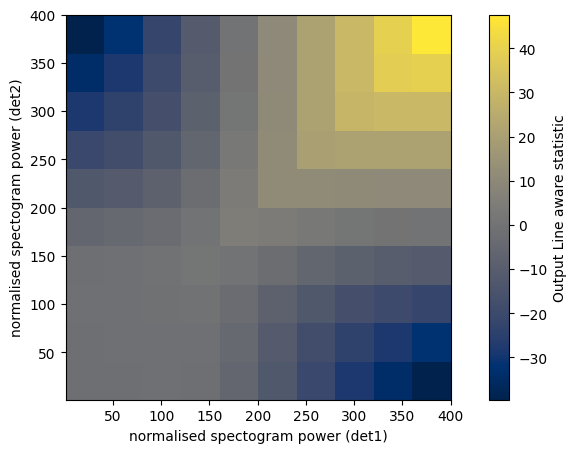

In [174]:
fig, ax = plt.subplots(figsize=(10,5))
img = ax.imshow(np.log(line_aware.signoiseline),origin="lower",extent=[powers.min(),powers.max(),powers.min(),powers.max()], cmap="cividis")
ax.set_xlabel("normalised spectogram power (det1)")
ax.set_ylabel("normalised spectogram power (det2)")
fig.colorbar(img, ax=ax, label="Output Line aware statistic")

In [175]:
line_H1_summed_power = copy.copy(spect.H1.summed_norm_sft_power)
line_H1_summed_power[:,60:70] += 400

In [176]:
soapout_line = soapcw.two_detector(transition_matrix, line_H1_summed_power, spect.L1.summed_norm_sft_power, lookup_table_2det=line_aware)

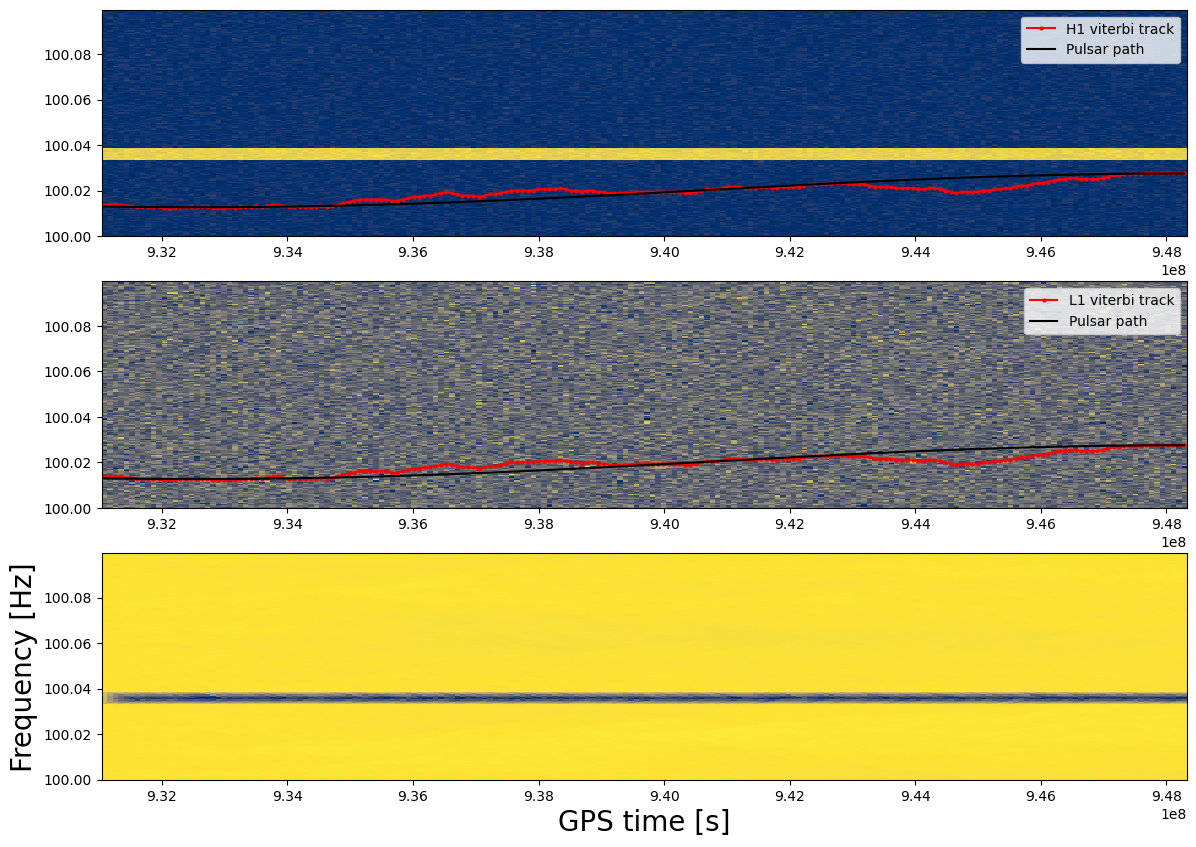

In [177]:
fig, ax = plt.subplots(nrows=3,figsize=(14,10))
ax[0].imshow(line_H1_summed_power.T,aspect="auto",origin="lower",extent=[spect.epochs.min(),spect.epochs.max(),spect.frequencies.min(),spect.frequencies.max()],cmap="cividis", interpolation="none")
ax[1].imshow(spect.L1.summed_norm_sft_power.T,aspect="auto",origin="lower",extent=[spect.epochs.min(),spect.epochs.max(),spect.frequencies.min(),spect.frequencies.max()],cmap="cividis", interpolation="none")
ax[0].plot(spect.epochs[::48] + half_day, spect.frequencies[soapout_line.vit_track1], color="r", marker="o", ms=2, label="H1 viterbi track")
ax[1].plot(spect.epochs[::48] + half_day, spect.frequencies[soapout_line.vit_track2], color="r", marker="o", ms=2, label="L1 viterbi track")

ax[0].plot(spect.epochs[::48] + half_day, h1_summed_pulsar_path, color="k", label="Pulsar path")
ax[1].plot(spect.epochs[::48] + half_day, h1_summed_pulsar_path, color="k", label="Pulsar path")
ax[2].imshow(np.log(soapout_line.vitmap.T),aspect="auto",origin="lower",extent=[spect.epochs.min(),spect.epochs.max(),spect.frequencies.min(),spect.frequencies.max()],cmap="cividis", interpolation="none")

ax[2].set_xlabel("GPS time [s]",fontsize=20)
ax[2].set_ylabel("Frequency [Hz]",fontsize=20)
ax[0].legend()
ax[1].legend()

# Data

Generating useable outputs from the search involves running on many narrow bands of data. We can do this on an example set provided. The provided data contains data with and without injections.

Noise: The noise is equivalent to a Gaussian noise time series, i.e. the power spectrum is a chi2 distribution with two degrees of freedom. 

Signal: The signal is injected with a given SNR, the square of which is used as the non centrality parameter for the noncentral chi2 distribution. The power is spread over multiple bins.

There is a third set of data here which contains some instrumental artefacts to more closely simulate real data.

Each of these datasets are a reduced set, so that we can run searches in a reasonable amount of time.
The duration is 20 days (1800s SFTs) and it covers a 4Hz frequency range (100-106 Hz), where each band in 0.02 Hz wide. As the spectrograms are summed over 1 day, this leaves us with images that are 20x36. 

The injected signals are all very loud with integrated SNRs in the range 30->40 over 10 days. This will allow the network to learn something with a reduced number of training examples. 

Prior on Signals

| name| symbol| range| info|
|-----|-----|-----|-----|
|right ascension | $\alpha$| $[0, 2\pi]$ | |
|declination | $\delta$| $[-\pi/2, \pi/2]$| |
|cos inclination |$\cos{\iota}$| $[0,1]$| |
|initial phase| $\phi_0$ | $[0,2\pi]$| |
|polarisation | $\psi$ | $[0, 2\pi]$| |
|frequency | $f$ | $[0.25 f_{\rm{min}}, 0.75 f_{\rm{min}}]$| place in middle half of narrowband|
|spin down |$\dot{f}$| $0$| |
|Integrated snr | $\rho$| [35, 60]| used to scale the h0 to noise floor|

Data info

| parameter| symbol| range| info|
|-----|-----|-----|-----|
|minimum frequency | $f_{min}$ | 100.0 Hz| |
|maximum frequency | $f_{max}$| 106.0 Hz| |
|sub-band width | | 0.02 Hz| 36 frequency bins|
|SFT length | | 1800s| |
|nuber summed SFTs|  | 48 | |
|Duration | $T$ | 24 days| (912, 1800s SFTs)|


One thing you will notice here is the bands have been split into an "even" and "odd" category. Each sub-band is alternately put in to each of the categories. This is so that a separate machine learning model can be trained on each and tested on the opposite, this means we are never training on testing data. 

In [ ]:
with h5py.File(even_file,"r") as f:
    print(f.keys())
    even_stats = np.array(f["stats"])
    even_imgs = np.transpose(np.array([np.array(f["H_imgs"]), np.array(f["L_imgs"]), np.array(f["vit_imgs"])]), (1, 0, 2, 3))
    even_labels = np.array(f["labels"])
    even_onehotlabels = torch.nn.functional.one_hot(torch.Tensor(even_labels).to(torch.int32).long(), 2).to(torch.float32)
    #even_snrs = np.array(f["pars"])[:,np.where(list(f["parnames"]) == "snr")]

In [ ]:
print(np.shape(even_imgs))

In [ ]:
with h5py.File(odd_file,"r") as f:
    print(f.keys())
    odd_stats = np.array(f["stats"])
    odd_imgs = np.transpose(np.array([np.array(f["H_imgs"]), np.array(f["L_imgs"]), np.array(f["vit_imgs"])]), (1, 0, 2, 3))
    odd_labels = np.array(f["labels"])
    odd_onehotlabels = torch.nn.functional.one_hot(torch.Tensor(odd_labels).to(torch.int32).long(), 2).to(torch.float32)

We can have a look at the data that is used in this example. We can see that this is a very small dataset with very load signal, this is to make the machine learning task later managable. 

### SFTs

In [ ]:
fig, ax = plt.subplots(nrows = 2, ncols = 10, figsize = (14, 6))
ind=3
vmin,vmax = odd_imgs[:10, :2].min(), odd_imgs[:10, :2].max()
for i in range(10):
    ax[0, i].imshow(odd_imgs[i,0].T, cmap="cividis",vmin=vmin, vmax=vmax)

for i in range(10):
    ax[1, i].imshow(odd_imgs[int(len(odd_imgs)/2) + i,0].T, cmap="cividis",vmin=vmin, vmax=vmax)
#ax.set_title(odd_labels[ind])

In [ ]:
fig, ax = plt.subplots(nrows = 2, ncols = 10, figsize = (14, 6))
ind=3
vmin,vmax = odd_imgs[:10, 2].min(), odd_imgs[:10, 2].max() -0.6
for i in range(10):
    img = ax[0, i].imshow(odd_imgs[i,2].T, cmap="cividis",vmin=vmin, vmax=vmax)
for i in range(10):
    img = ax[1, i].imshow(odd_imgs[int(len(odd_imgs)/2) + i,2].T, cmap="cividis",vmin=vmin, vmax=vmax)
#ax.set_title(odd_labels[ind])

SOAP can be run on all examples in this folder, we can use the included files as the lookup tables

In [ ]:
even_soapouts = np.zeros(len(even_imgs))
for index in range(len(even_imgs)):
    out = soapcw.two_detector(transition_matrix, even_imgs[index][0], even_imgs[index][1])
    # soapcw.two_detector(transition_matrix, H_imgs[index], L_imgs[index], lookup_table)
    even_soapouts[index] = out.max_end_prob

In [ ]:
odd_soapouts = np.zeros(len(odd_imgs))
for index in range(len(odd_imgs)):
    out = soapcw.two_detector(transition_matrix, odd_imgs[index][0], odd_imgs[index][1])
    # soapcw.two_detector(transition_matrix, H_imgs[index], L_imgs[index], lookup_table)
    odd_soapouts[index] = out.max_end_prob

In [ ]:
print(even_soapouts[:10])
print(even_stats[:10])

In [ ]:
fig, ax = plt.subplots(ncols=2, figsize=(14,6))
bins = np.linspace(min(odd_stats), max(odd_stats), 40)
hst = ax[0].hist(odd_stats[even_labels == 1], bins=bins, label="signal", alpha=0.5)
hst2 = ax[0].hist(odd_stats[even_labels == 0], bins=bins, label="noise", alpha=0.5)
ax[0].legend()
ax[0].set_xlabel("Viterbi statistic")
ax[0].set_ylabel("count")
ax[0].set_title("Line aware statistic")

bins = np.linspace(min(odd_soapouts), max(odd_soapouts), 30)
hst = ax[1].hist(odd_soapouts[even_labels == 1], bins=bins, label="signal", alpha=0.5)
hst2 = ax[1].hist(odd_soapouts[even_labels == 0], bins=bins, label="noise", alpha=0.5)
ax[1].legend()
ax[1].set_xlabel("Viterbi statistic")
ax[1].set_ylabel("count")
ax[1].set_title("Summed statistic")

# Machine Learning

So far we have a dataset from which we want to learn if a signal is present. This falls into the category of binary classification, where we want the model to predict how probable it is that a signal is present. When dealing with binary classification we want to minimise the Binary cross entropy between the truth and the predicted output. This is defined by

### Model Setup

We can define some parameters of out model here:

In [ ]:
in_channels = 3                                             # [H,L,vitmap]
outsize = 2                                                 # [noise_prob, signal_prob]
n_epochs = 4000                                             # number times all data is seen
learning_rate = 4e-4                                        # learning rate of the adam optimiser
device = "cuda:0" if torch.cuda.is_available() else "cpu"   # which device to put the model and data on (i.e. CPU or GPU if available)

you can print what gpus are available

In [ ]:
print(torch.cuda.device_count())

We can also check the size of our input spectrograms

In [ ]:
#imgshape
print(odd_imgs.shape)
print(even_imgs.shape)

The sequential model below is a simple way to build models, each layer follows the next.

In [ ]:
cnn = torch.nn.Sequential(
    torch.nn.Conv2d(in_channels, 4, (7,7), padding="same"),
    torch.nn.MaxPool2d((1,2)),
    torch.nn.ReLU(),
    torch.nn.Conv2d(4, 4, (3,3)),
    torch.nn.MaxPool2d((1,2)),
    torch.nn.ReLU(),
    torch.nn.AdaptiveAvgPool2d((2,2)),
    torch.nn.Flatten(),
    torch.nn.LazyLinear(16),
    torch.nn.Dropout(0.4),
    torch.nn.ReLU(),
    torch.nn.LazyLinear(8),
    torch.nn.Dropout(0.4),
    torch.nn.ReLU(),
    torch.nn.LazyLinear(outsize)
).to(device)

The same model can also be created via the SOAP interface, an example of the same model structure can be seen below.     

In [ ]:
model_soap = soapcw.cnn.pytorch.models.CNN(
    input_dim=(10,36),                          # the size of the input image
    fc_layers=[16, 8, 2],                       # the size of the fully connected mlp layers 
    conv_layers=[(4, 7, 2, 1), (4, 3, 2, 1)],   # the convolutional layers (num_filters, filter_size, maxpool_size, stride)
    inchannels=3, 
    avg_pool_size=(2,2),                        # the size of the average pooling layer 
    dropout=0.4,                                # the amount of dropout to use (default 0)
    device=device).to(device)                   # put the model on the chosen gpu or cpu

### Loss and Optimiser

It's at this stage that we specify the loss function to use and what optimiser to use.

The **optimiser** is the algorithm that is used to explore the parameter space of the network weights. In this example we're going to use `Adam` with a learning rate of 0.001 and the other parameters left as their default values. There a various different optimisers to choose from but Adam has proven to be realiable for a wide variety of problems and is a good place to start.

We then need to define the function that will quantify the network's performance, the **loss function**. In this case we're using **Categorical Crossentropy**. This combined with the **Softmax layer** means the network will ouput a vector of probabilities for each samples where each probability corresponds to a particular class.

For this binary (noise/signal) case it can written as:

$$f(\theta) = - \sum_{i \in S} log(\theta_{i}^{S}) - \sum_{i \in N} log(\theta_{i}^{N})$$

where $\theta_{i}^{S/N}$ is the predicted probability of class signal-noise (S) or noise-only (N)

In [ ]:
optimiser = torch.optim.Adam(cnn.parameters(), lr=learning_rate)
loss_fn = torch.nn.BCEWithLogitsLoss()

In [178]:
def train_batch(model, optimiser, loss_function, data, labels, train=True):
    """
    Compute the loss for one batch of training/validation data. If train=True update the model.
    Args
    -------
    model: 
        pytorch model
    optimiser:
    loss_function:
    data: Tensor
    labels: Tensor
    train: bool
        if true updates the model weights and optimiser
    """
    model.train(train)
    if not train:
        model.eval()
        
    # zero the gradients so they do not grow with time
    if train:
        optimiser.zero_grad()

    # pass the data through the model to get two outputs (prob noise, prob signal)
    outputs = model(data)
    # computs the loss from our outputs and labels
    loss = loss_function(outputs, labels)

    if train:
        # perform a backward pass computing the gradients within the network
        loss.backward()
        # take a step in the direction of these gradients
        optimiser.step()

    return loss.item()


Move all the data to the GPU (if the gpu is available)

In [ ]:
even_imgs = torch.Tensor(even_imgs).to(device)
odd_imgs = torch.Tensor(odd_imgs).to(device)
even_onehotlabels = even_onehotlabels.to(device)
odd_onehotlabels = odd_onehotlabels.to(device)

We can now write out simple training loop. 

In [ ]:
tr_losses = np.zeros(n_epochs)
val_losses = np.zeros(n_epochs)
# define a random 200 indices for the validation data
val_inds = np.random.uniform(0, len(odd_imgs), 200).astype(int)
for epoch in range(n_epochs):

    # train a batch on all of the "even" data
    tr_loss = train_batch(cnn, optimiser, loss_fn, even_imgs[:,:], even_onehotlabels, train=True)

    # dont compute gradients for the test data 
    with torch.no_grad():
        val_loss = train_batch(cnn, optimiser, loss_fn, odd_imgs[val_inds,:], odd_onehotlabels[val_inds], train=False)

    # save the training and validation losses to array to look at later
    tr_losses[epoch] = tr_loss
    val_losses[epoch] = val_loss

    if epoch % 50 == 0:
        print(f"Epoch: {epoch}, loss: {tr_loss}, val_loss: {val_loss}")

We can have a look at how the loss evolves during training. From this plot it appears there is a little bit of a generalisation gap, where the validations loss and training loss diverge. As we are using such a small data set this is not surprising, the network has been simplified as much as possible to reduce this. When training for actual observing runs the data set will have > 100k examples rather than 3k which reduces this affect and improves the networks ability to generalise. 

In [ ]:
fig, ax = plt.subplots()
ax.plot(tr_losses, label="Training loss")
ax.plot(val_losses, label="Validation Loss")
ax.set_yscale("log")
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")

We can now test this method on the "odd" bands to see how it performs on data it has not yet seen

In [ ]:
cnn.eval()
with torch.no_grad():
    odd_outputs = cnn(torch.Tensor(odd_imgs[:,:])).cpu()

We can compute how well the cnn and SOAP performs by measuring the true positive rate at a false alarm of 1%.

In [ ]:
cnn_99per = sorted(odd_outputs[odd_labels==0][:,0])[int(0.99*len(odd_outputs[odd_labels==0]))]
soap_99per = sorted(odd_soapouts[odd_labels==0])[int(0.99*len(odd_outputs[odd_labels==0]))]
print(cnn_99per.numpy(), soap_99per)
cnn_sigfrac = sum(odd_outputs[odd_labels==1][:,1] > cnn_99per)/len(odd_outputs[odd_labels==1])
soap_sigfrac = sum(odd_soapouts[odd_labels==1] > soap_99per)/len(odd_outputs[odd_labels==1])
print("cnn true positive rate: ", cnn_sigfrac.numpy())
print("soap true positive rate: ", soap_sigfrac)

We can see that it reaches close to the same sensitivity on this dataset with only a small amount of training and a small network.

In [ ]:
fig, ax = plt.subplots(ncols = 2, figsize=(14,5))
h11 = ax[0].hist(odd_outputs[odd_labels==0][:,1], bins=np.arange(-1,50), alpha=0.5)
h12 = ax[0].hist(odd_outputs[odd_labels==1][:,1], bins=np.arange(-1,50), alpha=0.5)
ax[0].axvline(cnn_99per, color="r")
ax[0].set_yscale("log")
h11 = ax[1].hist(torch.nn.functional.sigmoid(odd_outputs[odd_labels==0][:,1]), bins=30, alpha=0.5)
h12 = ax[1].hist(torch.nn.functional.sigmoid(odd_outputs[odd_labels==1][:,1]), bins=30, alpha=0.5)
ax[1].axvline(torch.nn.functional.sigmoid(cnn_99per), color="r")

## Loading a pretrained model
Links to other pretrained models are in the ligo private pages here if needed, I've provided an example in this repo for those who do not have access.

In [ ]:
model_soap, model_config = soapcw.cnn.pytorch.load_model_from_config(
        config_file, 
        weight_file, 
        device=device)

This can be tested on the above data (this is not an entirely fair test as the SNR distributions it was trained on are slightly different)

In [ ]:
model_soap.eval()
with torch.no_grad():
    s_odd_outputs = model_soap(torch.Tensor(odd_imgs)).cpu()

In [ ]:
fig, ax = plt.subplots(ncols = 1, figsize=(8,5))
bins = np.linspace(min(s_odd_outputs[:,1]), max(s_odd_outputs[:,1]), 20)
h11 = ax.hist(s_odd_outputs[odd_labels==0][:,1], alpha=0.5, bins=bins)
h12 = ax.hist(s_odd_outputs[odd_labels==1][:,1], alpha=0.5, bins=bins)
#ax[0].set_yscale("log")


We can test this network on the data we simulated at the start of this notebook

In [ ]:
test_data = torch.unsqueeze(torch.Tensor(np.stack([spect.H1.summed_norm_sft_power.T, spect.H1.summed_norm_sft_power.T, soapout.vitmap.T])), 0)
test_data.shape

In [ ]:
with torch.no_grad():
    s_odd_test = model_soap(test_data)

In [ ]:
s_odd_test

# Neville 